# Timeseries Forecasting of Solar Flares using LSTM

In [1]:
import pandas as pd
import pickle
from keras.models import load_model
from keras import Sequential
from keras.layers import LSTM, SimpleRNN, GRU, Dense
from keras.losses import SparseCategoricalCrossentropy
from keras.callbacks import EarlyStopping
import numpy as np
from sklearn.metrics import ConfusionMatrixDisplay
import os
from sklearn.metrics import precision_recall_fscore_support

In [2]:
def loadPickledFile(fileName):
    bytes_in = bytearray(0)
    max_bytes = 2**31 - 1
    input_size = os.path.getsize(fileName)
    with open(fileName, 'rb') as file:
        for _ in range(0, input_size, max_bytes):
            bytes_in += file.read(max_bytes)
        obj = pickle.loads(bytes_in)
        file.close()
    return obj

## Data Cleaning

As shown in analysisAndVisualization, there are 6 magnetic field parameters which are highly correlated with flare type. These 6 are the features we will use for the LSTM. The LSTM model will take in 24 hours of past magnetic field data, and predict what the most severe solar flare in the next hour will be. The data contains a major class imbalance, so we created a new dataset with more balanced classes in order to prevent overfitting. We will train on the balanced data, then test on the real data. The code for creation of this balanced dataset can be found in `create_balanced_datasets.py`. 

In [7]:
X_train = loadPickledFile("balanced_data/X_train.pck")
X_test = loadPickledFile("balanced_data/X_test.pck")
y_train = loadPickledFile("balanced_data/y_train.pck")
y_test = loadPickledFile("balanced_data/y_test.pck")

## Create Neural Net

Recurrent Neural Networks such as the LSTM are well-suited for timeseries forecasting, so our model will just be a simple LSTM. This is a multi-class classification problem, so categorical cross entropy is the most suitable loss function, and the softmax function is the most suitable activation function for the output layer.

In [46]:
num_features = X_train[0].shape[1]
num_classes = 5
model = Sequential()
# Input Layer
model.add(Dense(num_features, input_shape=X_train[0].shape,activation='relu'))
# Hidden Layers: RNN
model.add(LSTM(units=20*num_features)) # Add return_sequences=True if you want to add more architecture
# model.add(GRU(units=2*num_features, return_sequences=True))
# model.add(SimpleRNN(units=2*num_features))
# Output Layer
model.add(Dense(num_classes, activation='softmax'))

model.compile(optimizer='adam', loss=SparseCategoricalCrossentropy())
model.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_36 (Dense)            (None, 120, 6)            42        
                                                                 
 lstm_11 (LSTM)              (None, 120)               60960     
                                                                 
 dense_37 (Dense)            (None, 5)                 605       
                                                                 
Total params: 61607 (240.65 KB)
Trainable params: 61607 (240.65 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


## Training

We will reserve 20% of the training data for validation, and train the network. If the validation loss stops improving, we will stop training so the model does not overfit. 

In [47]:
epochs = 100
val_split = 0.2
model.fit(X_train,
          y_train,
          validation_split=val_split,
          epochs=epochs,
          verbose=1,
          callbacks=[EarlyStopping(monitor='val_loss', patience=5)],
          shuffle=True)

Epoch 1/100
235/235 [==============================] - 20s 75ms/step - loss: 1.0107 - val_loss: 0.9381
Epoch 2/100
235/235 [==============================] - 17s 73ms/step - loss: 0.9521 - val_loss: 0.9356
Epoch 3/100
235/235 [==============================] - 19s 79ms/step - loss: 0.9428 - val_loss: 0.9262
Epoch 4/100
235/235 [==============================] - 19s 79ms/step - loss: 0.9297 - val_loss: 0.9261
Epoch 5/100
235/235 [==============================] - 18s 77ms/step - loss: 0.9213 - val_loss: 0.9244
Epoch 6/100
235/235 [==============================] - 19s 81ms/step - loss: 0.9150 - val_loss: 0.9212
Epoch 7/100
235/235 [==============================] - 17s 73ms/step - loss: 0.9115 - val_loss: 0.9045
Epoch 8/100
235/235 [==============================] - 21s 88ms/step - loss: 0.9058 - val_loss: 0.8955
Epoch 9/100
235/235 [==============================] - 19s 79ms/step - loss: 0.9042 - val_loss: 0.8947
Epoch 10/100
235/235 [==============================] - 18s 75ms/step - l

## Persisting Model

Next, we persist the model so it can be used later.

In [48]:
modelName = "lstm-balanced"
model.save(f"persisted_nets/{modelName}")

INFO:tensorflow:Assets written to: persisted_nets/lstm-balanced\assets


INFO:tensorflow:Assets written to: persisted_nets/lstm-balanced\assets


## Loading and Evaluating Model

Now, we can load the model back in from the file, and evaluate it. First, we will evaluate it on the balanced dataset. Then, we can evaluate it on real timeseries data. 

In [3]:
modelName = "lstm-balanced"
model = load_model(f"persisted_nets/{modelName}")

In [9]:
classLabels = {
    0: "0",
    1: "B",
    2: "C",
    3: "M",
    4: "X"
}

def threshold_output(output):
    thresholded = []
    for arr in output:
        thresholded.append(np.array([np.array([np.argmax(arr)])]))
    return np.array(thresholded)
    
def printMetrics(p,r,f,s):
    for i in range(len(p)):
        print(f"Metrics for {classLabels[i]} class flares")
        print(f"\tPrecision: {p[i]}")
        print(f"\tRecall:    {r[i]}")
        print(f"\tF-Score:   {f[i]}")
        print(f"\tSupport:   {s[i]}")

def evaluate_model(model,X_test,y_test, plotTitle):
    y_pred = model.predict(X_test)
    y_pred = threshold_output(y_pred)

    p,r,f,s = precision_recall_fscore_support(y_test.flatten(), y_pred.flatten())

    printMetrics(p,r,f,s)
    
    disp = ConfusionMatrixDisplay.from_predictions(y_test.flatten(), y_pred.flatten(), display_labels=["No Flare","B", "C", "M", "X"])
    disp.ax_.set_title(plotTitle)

126/126 [==============================] - 2s 19ms/step
Metrics for 0 class flares
	Precision: 0.853125
	Recall:    0.6319444444444444
	F-Score:   0.7260638297872339
	Support:   432
Metrics for B class flares
	Precision: 0.49903846153846154
	Recall:    0.5766666666666667
	F-Score:   0.5350515463917526
	Support:   900
Metrics for C class flares
	Precision: 0.6565074135090609
	Recall:    0.776803118908382
	F-Score:   0.7116071428571428
	Support:   2052
Metrics for M class flares
	Precision: 0.6495726495726496
	Recall:    0.25675675675675674
	F-Score:   0.36803874092009686
	Support:   592
Metrics for X class flares
	Precision: 0.0
	Recall:    0.0
	F-Score:   0.0
	Support:   46


c:\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


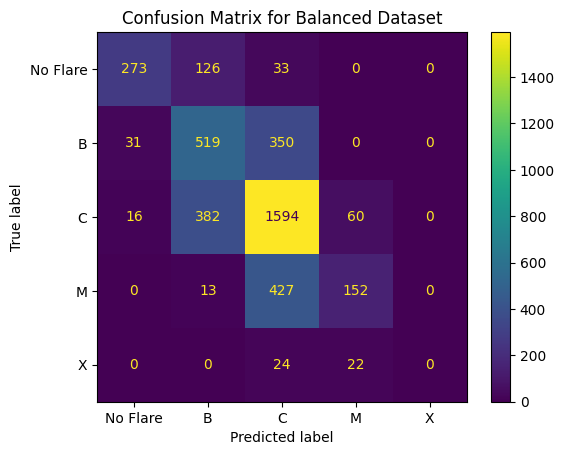

In [10]:
evaluate_model(model, X_test, y_test, "Confusion Matrix for Balanced Dataset")

As shown in the metrics and confusion matrix above, the model has a difficult time predicting X-class flares. This is likely because the number of X-class flares is small. In the future, we can improve the prediction of X-class flares by using a more deep, sophisticated model.

## Evaluation of the Model on Unbalanced Data

Real solar flare data is **very** unbalanced, so we need to see how our model performs on the real, unbalanced data. The data used for this evaluation is just data from the year 2014, transformed into a format which the LSTM can take. Creation of this dataset is done in `create_LSTM_datasets.py`

In [11]:
X_train = loadPickledFile("timeseries/X_train.pck")
X_test = loadPickledFile("timeseries/X_test.pck")
y_train = loadPickledFile("timeseries/y_train.pck")
y_test = loadPickledFile("timeseries/y_test.pck")

4596/4596 [==============================] - 94s 20ms/step


c:\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Metrics for 0 class flares
	Precision: 0.9959199252425012
	Recall:    0.5777450314186894
	F-Score:   0.7312710193668096
	Support:   130973
Metrics for B class flares
	Precision: 0.026728110599078342
	Recall:    0.6187766714082503
	F-Score:   0.051242784780303925
	Support:   2109
Metrics for C class flares
	Precision: 0.3355443403028118
	Recall:    0.6038927335640139
	F-Score:   0.431391935733045
	Support:   11560
Metrics for M class flares
	Precision: 0.5290055248618785
	Recall:    0.3958656330749354
	F-Score:   0.4528524977830328
	Support:   1935
Metrics for X class flares
	Precision: 0.0
	Recall:    0.0
	F-Score:   0.0
	Support:   480


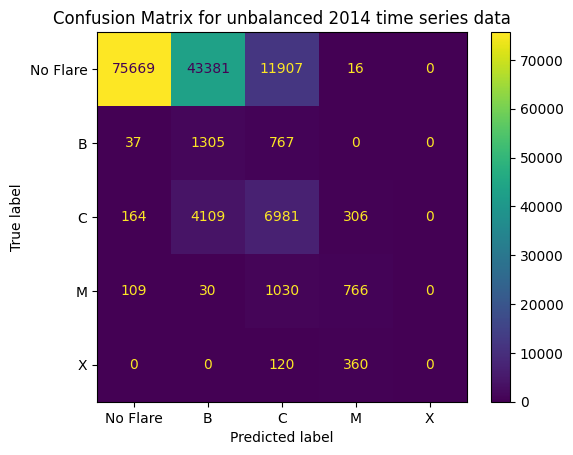

In [12]:
evaluate_model(model, X_test, y_test, "Confusion Matrix for unbalanced 2014 time series data")

As shown in the confusion matrix and metrics above, our model has difficulties discerning between the "No Flare" case and B- and C- class flares. Because of the severity of M and X class flares, they are more important to predict than the less severe solar flares, and we see that the recall of M-class flares is around 40%, which for a simple model is not bad for timeseries prediction. The X-class prediction, however, is not at all good, with no flares being correctly predicted. Once again, a more sophisticated, deep machine learning model would help to make this better. With solar flares, predicting the "No Flare" condition is not as important as predicting a solar flare, so the metrics we care most about are the **recall** for each of the solar flare classes. The recall of the B- and C- class flares are around 60%, which is acceptable. The M- and X- class recall are not as favorable, as mentioned above.